In [1]:
from __future__ import print_function
import pickle 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from sub import subMNIST
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
%matplotlib inline

Files already downloaded
3000
750


In [2]:
#Set labels to zeros as a dummy values to make the train_loader work 

trainset_unlabeled = pickle.load(open("train_unlabeled.p", "rb")) 
trainset_unlabeled.train_labels = torch.zeros(trainset_unlabeled.train_data.size(0))
train_loader  = torch.utils.data.DataLoader(trainset_unlabeled, batch_size=64, shuffle=True, num_workers=2)

validset = pickle.load(open("validation.p", "rb"))
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)

In [3]:
#Model Architecture

encoder = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(1, 16, kernel_size=3)), 
          ('relu1', nn.ReLU()),
          
          ('conv2', nn.Conv2d(16, 8, kernel_size=3)),
          ('relu2', nn.ReLU()),
          
          ('conv3', nn.Conv2d(8, 8, kernel_size=3)),
          ('relu3', nn.ReLU()),
        ]))

decoder = nn.Sequential(OrderedDict([
          ('conv1', nn.ConvTranspose2d(8, 8, kernel_size=3)), 
          ('relu1', nn.ReLU()),
          
          ('conv2', nn.ConvTranspose2d(8, 16, kernel_size=3)),
          ('relu2', nn.ReLU()),
          
          ('conv3', nn.ConvTranspose2d(16, 1, kernel_size=3)),
          ('relu3', nn.ReLU()),
          ('sigmoid4', nn.Sigmoid())
            
        ]))

model =  nn.Sequential(OrderedDict([
          ('encoder', encoder),
          ('decoder', decoder),
        ]))

In [4]:
# Measuring the error of a reconstruction with BCE Loss which is usually used for autoencoders 
# BCE Loss requires the "targert" and "data" to be an output btw 0 and 1
# Therefore, we usually call sigmoid on the target before wrapping it into a Variable

loss_function = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def train(epoch):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):

        target = Variable(F.sigmoid(data))
        data = Variable(data)  
        optimizer.zero_grad() 
        output = model(data) 
        loss = loss_function(output, target) 
        loss.backward() 
        optimizer.step()
        if batch_idx % 40 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0])) 

In [6]:
def test(epoch, valid_loader):
    loss = 0
    for data, _ in valid_loader:
        target = Variable(F.sigmoid(data))
        data = Variable(data, volatile=True)
        output = model(data)
        loss += loss_function(output, target)
    print(loss) 

In [7]:
for epoch in range(1, 2):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/47000 (0%)]	Loss: 0.694329
Train Epoch: 1 [2560/47000 (5%)]	Loss: 0.642617
Train Epoch: 1 [5120/47000 (11%)]	Loss: 0.641042
Train Epoch: 1 [7680/47000 (16%)]	Loss: 0.639820
Train Epoch: 1 [10240/47000 (22%)]	Loss: 0.640832
Train Epoch: 1 [12800/47000 (27%)]	Loss: 0.641793
Train Epoch: 1 [15360/47000 (33%)]	Loss: 0.639884
Train Epoch: 1 [17920/47000 (38%)]	Loss: 0.633764
Train Epoch: 1 [20480/47000 (44%)]	Loss: 0.638952
Train Epoch: 1 [23040/47000 (49%)]	Loss: 0.639485
Train Epoch: 1 [25600/47000 (54%)]	Loss: 0.636046
Train Epoch: 1 [28160/47000 (60%)]	Loss: 0.636713
Train Epoch: 1 [30720/47000 (65%)]	Loss: 0.639681
Train Epoch: 1 [33280/47000 (71%)]	Loss: 0.638629
Train Epoch: 1 [35840/47000 (76%)]	Loss: 0.635301
Train Epoch: 1 [38400/47000 (82%)]	Loss: 0.638131
Train Epoch: 1 [40960/47000 (87%)]	Loss: 0.638629
Train Epoch: 1 [43520/47000 (93%)]	Loss: 0.639996
Train Epoch: 1 [46080/47000 (98%)]	Loss: 0.637344
Variable containing:
 99.8524
[torch.FloatTensor of size 1]

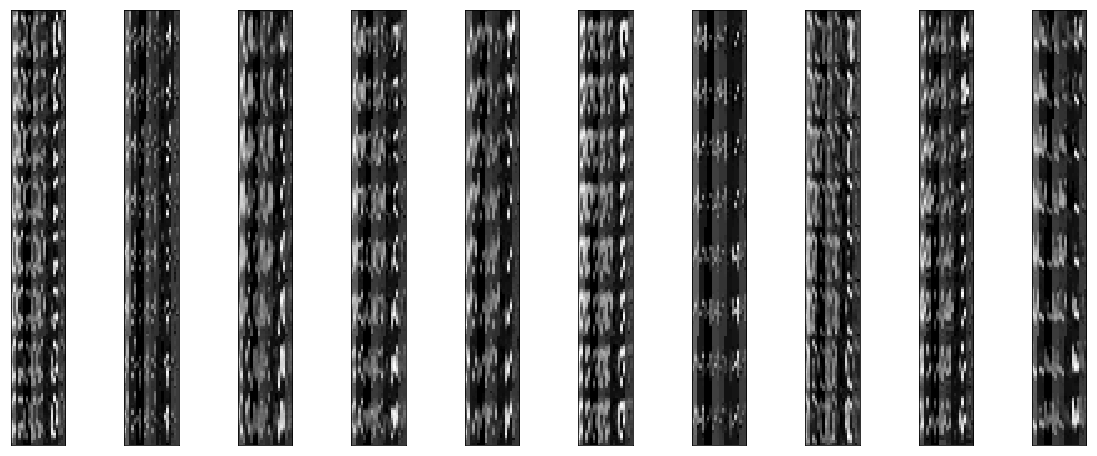

In [8]:
# Encoder Test_drive: visualizing the latent space 

dataiter = iter(valid_loader) 
data, _ = dataiter.next()
output = encoder(Variable(data))

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(output.data[i].numpy().reshape(22, 22 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

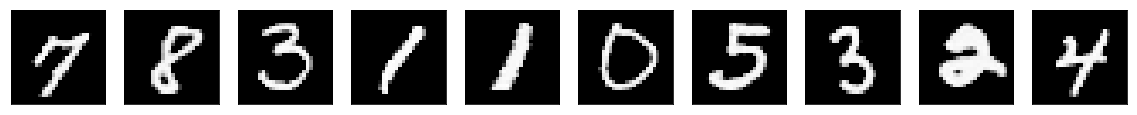

In [9]:
# Model Test_Drive: Reconstructing/Generating images  

dataiter = iter(valid_loader) 
data, _ = dataiter.next()
output = model(Variable(data))

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(output[i].data.view(28, 28).numpy())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##                                 The start of the semi_supervised model

In [10]:
trainset_labeled = pickle.load(open("train_labeled.p", "rb")) 
train_loader  = torch.utils.data.DataLoader(trainset_labeled, batch_size=64, shuffle=True, num_workers=2)

In [11]:
# Setting model's parameters
for p in model.parameters():
    p.requires_grad = False

In [12]:
# Conv Semi_supervised 
# Uncomment this if you want the conv semi_supervised 


# class SemiSupervised(nn.Module):
#     def __init__(self):
#         super(SemiSupervised, self).__init__()
        
#         self.conv1 = nn.Conv2d(8, 16, kernel_size=5)
#         self.conv2 = nn.Conv2d(16, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1   = nn.Linear(20*2*2, 40) 
#         self.fc2   = nn.Linear(40, 20)
#         self.fc3   = nn.Linear(20, 10)
        
#     def forward(self, x):
#         x = encoder(x)
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
#         x = x.view(-1, 20*2*2)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return F.log_softmax(x)

# semi_model = SemiSupervised()

In [14]:
# Linear semi_supervised 

class SemiSupervised(nn.Module):
    
    def __init__(self):
        super(SemiSupervised, self).__init__()
        self.fc1   = nn.Linear(3872, 1000) 
        self.fc2   = nn.Linear(1000, 60)
        self.fc3   = nn.Linear(60, 10)
        
    def forward(self, x):
        
        x = encoder(x)
        x = x.view(-1, 3872)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

semi_model = SemiSupervised()

In [15]:
optimizer = optim.Adam(semi_model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

In [16]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = Variable(data)
        target = Variable(target)
        optimizer.zero_grad()
        output = semi_model(data) 
        loss =  loss_function(output, target) 
        loss.backward() 
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))


In [17]:
def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:

        data, target = Variable(data, volatile=True), Variable(target)
        output = semi_model(data)
        test_loss += loss_function(output, target).data[0]
        pred = output.data.max(1)[1] 
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [18]:
for epoch in range(1, 20):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.307818
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.240829
Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.085594
Train Epoch: 1 [1920/3000 (64%)]	Loss: 1.845409
Train Epoch: 1 [2560/3000 (85%)]	Loss: 1.768907

Test set: Average loss: 1.4969, Accuracy: 4921/10000 (49%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 1.473390
Train Epoch: 2 [640/3000 (21%)]	Loss: 1.378075
Train Epoch: 2 [1280/3000 (43%)]	Loss: 1.089066
Train Epoch: 2 [1920/3000 (64%)]	Loss: 0.973316
Train Epoch: 2 [2560/3000 (85%)]	Loss: 1.019352

Test set: Average loss: 0.9879, Accuracy: 6914/10000 (69%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 1.107687
Train Epoch: 3 [640/3000 (21%)]	Loss: 0.885968
Train Epoch: 3 [1280/3000 (43%)]	Loss: 0.895164
Train Epoch: 3 [1920/3000 (64%)]	Loss: 0.581930
Train Epoch: 3 [2560/3000 (85%)]	Loss: 0.709436

Test set: Average loss: 0.7343, Accuracy: 7820/10000 (78%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.550681
Train Epoch: 4 [640/3000 (21%)]	Loss: 0.676181
Train Epoch: 4 [1280/